In [1]:
%cd ..

/home/elias/work/sparse


In [28]:
%matplotlib nbagg

from time import time
import random
from collections import Counter

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.utils import make_grid
from kymatio import Scattering2D
from kymatio.scattering2d.utils import fft2
from colorsys import hls_to_rgb

from dataset import ImageDataset, EmbeddingDataset

In [3]:
J = 4
L = 8

scattering = Scattering2D(J, (64, 64), L=L)

In [22]:
def colorize(z):
    n, m = z.shape
    c = np.zeros((n, m, 3))
    c[np.isinf(z)] = (1.0, 1.0, 1.0)
    c[np.isnan(z)] = (0.5, 0.5, 0.5)

    idx = ~(np.isinf(z) + np.isnan(z))
    A = (np.angle(z[idx]) + np.pi) / (2*np.pi)
    A = (A + 0.5) % 1.0
    B =  1.0/(1.0+abs(z[idx])**0.3)
    c[idx] = [hls_to_rgb(a, b, 0.8) for a,b in zip(A,B)]
    return c

<IPython.core.display.Javascript object>


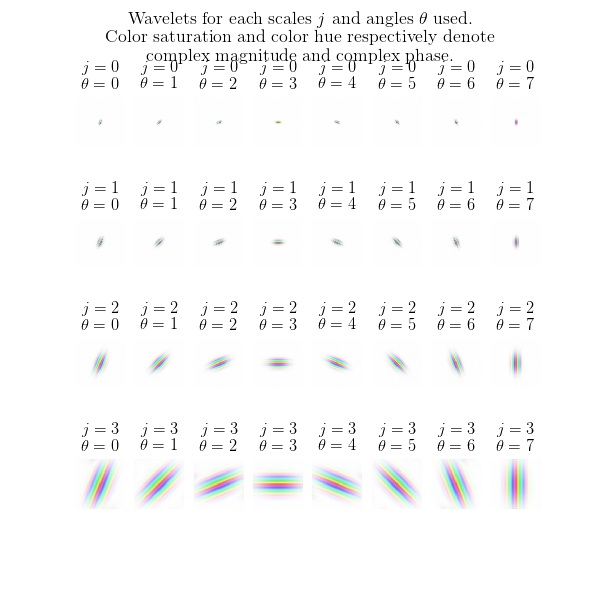

In [23]:
fig, axs = plt.subplots(J, L, sharex=True, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(6)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
i=0
for filter in scattering.Psi:
    f_r = filter[0][...,0].numpy()
    f_i = filter[0][..., 1].numpy()
    f = f_r + 1j*f_i
    filter_c = fft2(f)
    filter_c = np.fft.fftshift(filter_c)
    axs[i // L, i % L].imshow(colorize(filter_c))
    axs[i // L, i % L].axis('off')
    axs[i // L, i % L].set_title("$j = {}$ \n $\\theta={}$".format(i // L, i % L))
    i = i+1

fig.suptitle("Wavelets for each scales $j$ and angles $\\theta$ used."
"\n Color saturation and color hue respectively denote\ncomplex magnitude and complex phase.\n", fontsize=13)
fig.show()

<IPython.core.display.Javascript object>


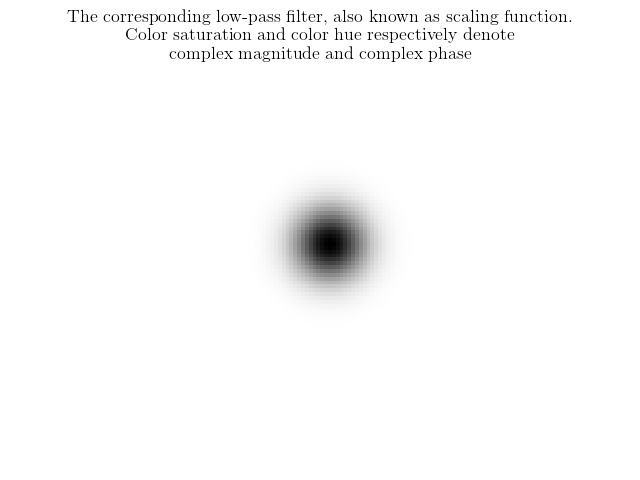

In [24]:
plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.axis('off')
plt.set_cmap('gray_r')

f_r = scattering.Phi[0][..., 0].numpy()
f_i = scattering.Phi[0][..., 1].numpy()
f = f_r + 1j*f_i

filter_c = fft2(f)
filter_c = np.fft.fftshift(filter_c)
plt.suptitle("The corresponding low-pass filter, also known as scaling function.\n"
"Color saturation and color hue respectively denote\ncomplex magnitude and complex phase", fontsize=13)
filter_c = np.abs(filter_c)
plt.imshow(filter_c)

In [18]:
def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    

def show_class(label, assigned_labels, dataset):
    idx = []
    for i, lb in enumerate(assigned_labels):
        if lb == label:
            idx.append(i)
    
    print(f"found {len(idx)} for class {label}")
    idxs = random.sample(idx, 25)
    imgs = [dataset[it]['x'] * 255 for it in idxs]
    show(make_grid(imgs, nrow=5))

In [4]:
transform = Compose([
    Resize((64, 64)),
    ToTensor()
])
images_d = ImageDataset(transform)

dataset = EmbeddingDataset()
dataloader = DataLoader(dataset, batch_size=400, pin_memory=True, num_workers=7)

found 3500 for class simpsons


<IPython.core.display.Javascript object>


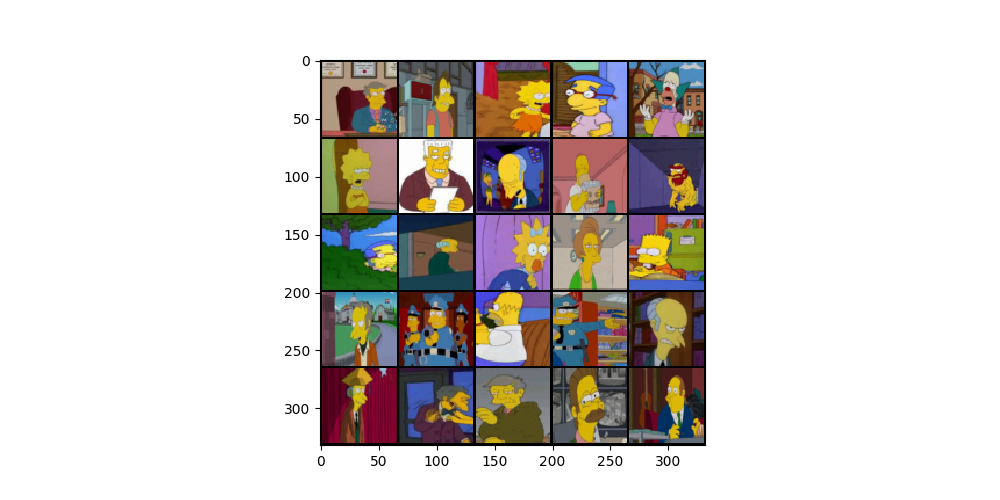

In [23]:
show_class('simpsons', correct_labels, images_d)

<IPython.core.display.Javascript object>


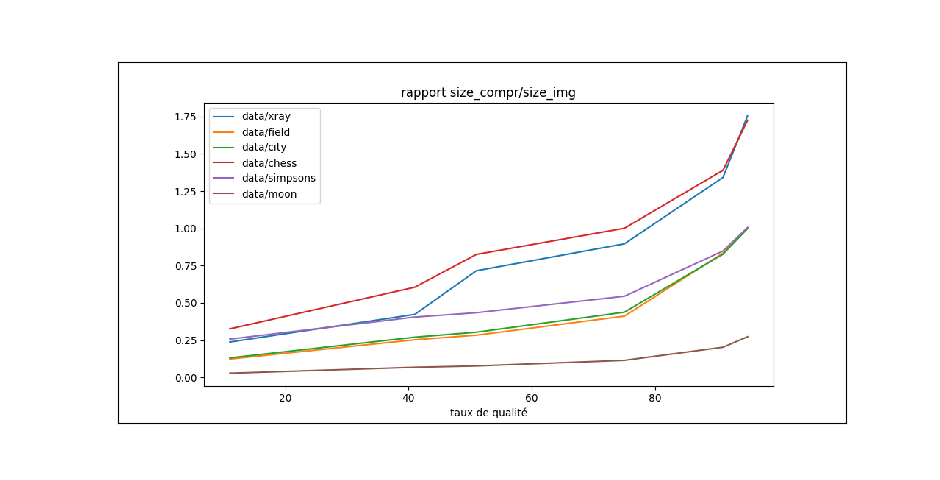

In [30]:
compression_plot = mpimg.imread('combined.png')

plt.figure()
plt.imshow(compression_plot)
plt.xticks([])
plt.yticks([])
plt.show()

In [6]:
RANDOM_STATE = 23

Kmeans = MiniBatchKMeans(24, random_state=RANDOM_STATE)

In [7]:
for idx_batch, current_batch in enumerate(tqdm(dataloader)):
    features = current_batch['x'].view(current_batch['x'].shape[0], -1).numpy()
    Kmeans.partial_fit(features)

100%|██████████| 38/38 [01:13<00:00,  1.94s/it]


In [8]:
correct_labels = []
labels = []
for idx_batch, current_batch in enumerate(tqdm(dataloader)):
    correct_labels += current_batch['y']
    features = current_batch['x'].view(current_batch['x'].shape[0], -1).numpy()
    labels += Kmeans.predict(features).tolist()

100%|██████████| 38/38 [01:18<00:00,  2.06s/it]


In [10]:
Counter(correct_labels)

Counter({'field': 491,
         'moon': 3500,
         'simpsons': 3500,
         'xray': 3500,
         'chess': 3500,
         'city': 333})

In [11]:
count = {}
for i, lb in enumerate(correct_labels):
    if labels[i] not in count:
        count[labels[i]] = {}
    if lb not in count[labels[i]]:
        count[labels[i]][lb] = 1
    else:
        count[labels[i]][lb] += 1
        

inv_count = {}
for i, lb in enumerate(labels):
    if correct_labels[i] not in inv_count:
        inv_count[correct_labels[i]] = {}
    if lb not in inv_count[correct_labels[i]]:
        inv_count[correct_labels[i]][lb] = 1
    else:
        inv_count[correct_labels[i]][lb] += 1

<IPython.core.display.Javascript object>


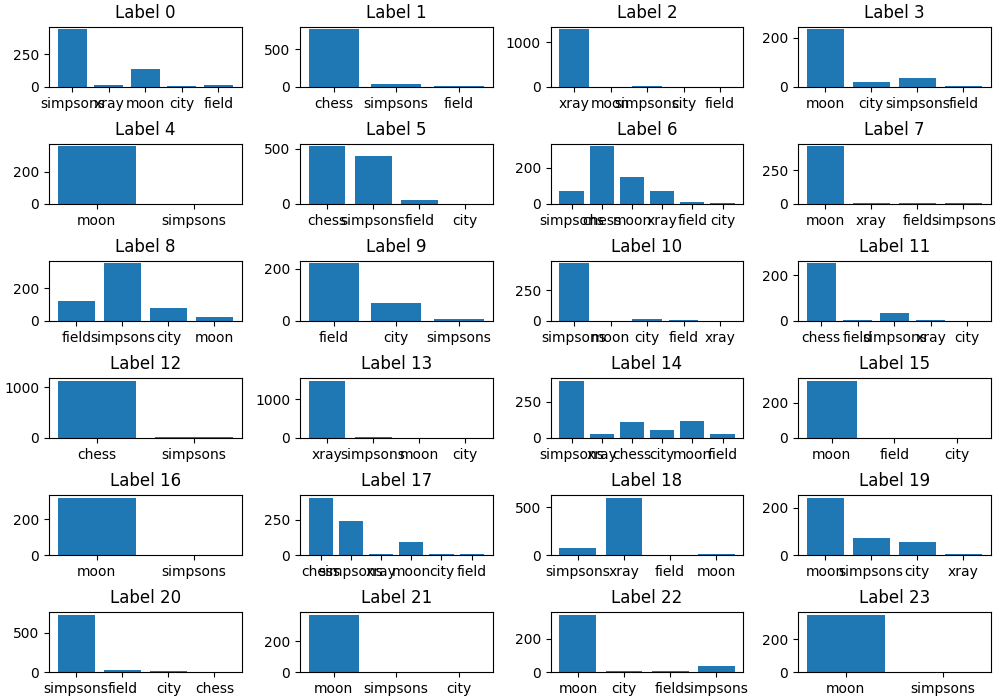

In [12]:
fig = plt.figure(constrained_layout=True, figsize=(10, 7))
spec = gridspec.GridSpec(ncols=4, nrows=len(count)//4, figure=fig)
for c, l in sorted(count.items()):
    tempfig = fig.add_subplot(spec[c//4, c%4])
    tempfig.set_title(f"Label {c}")
#     plt.gca().set_yticks([])
    plt.bar(l.keys(), l.values())

<IPython.core.display.Javascript object>


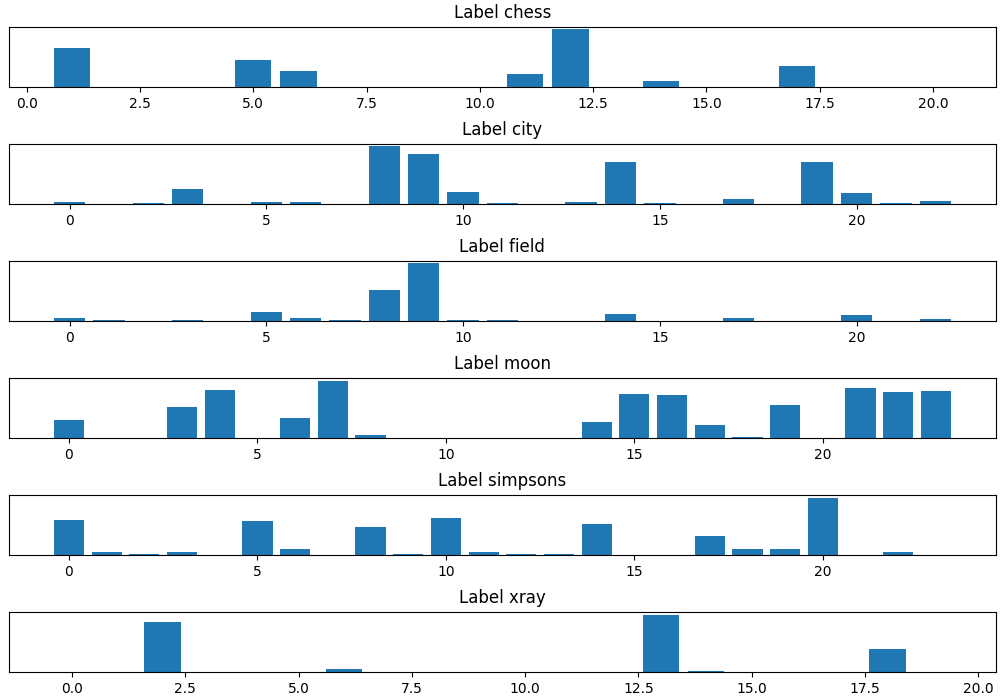

In [13]:
fig = plt.figure(constrained_layout=True, figsize=(10, 7))
spec = gridspec.GridSpec(ncols=1, nrows=len(inv_count), figure=fig)
i = 0
for c, l in sorted(inv_count.items()):
    tempfig = fig.add_subplot(spec[i, 0])
    tempfig.set_title(f"Label {c}")
    plt.gca().set_yticks([])
    plt.bar(l.keys(), l.values())
    i += 1

found 686 for class 18


<IPython.core.display.Javascript object>


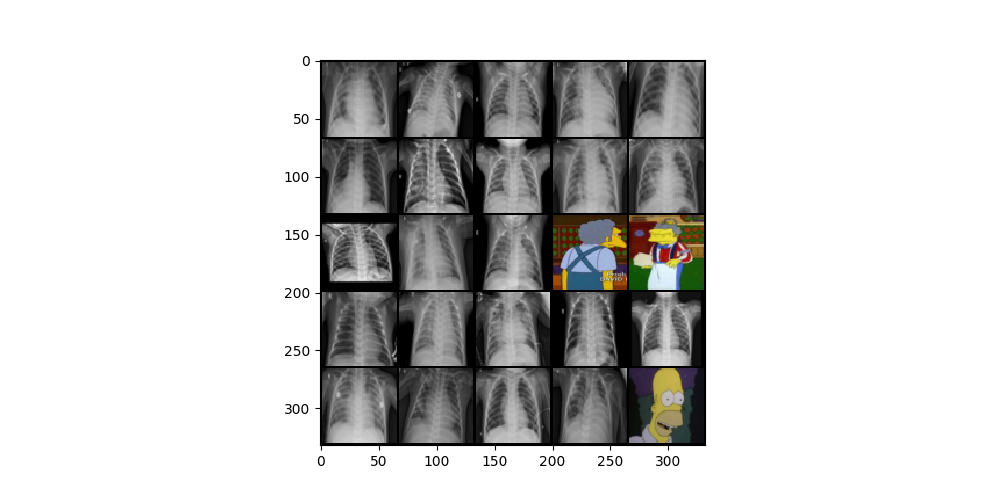

In [16]:
show_class(18, labels, images_d)

In [12]:
benchmark = [1, 5, 10, 50, 70, 100, 200, 300, 400, 500]
times = []

for bs in tqdm(benchmark):
    imageloader = DataLoader(images_d, batch_size=bs, pin_memory=True, num_workers=7)
    batch = next(iter(imageloader))['x']
    start = time()
    features = scattering(batch).view(bs, -1).numpy()
    labels = Kmeans.predict(features)
    stop = time()
    times.append((stop - start)/bs)

100%|██████████| 10/10 [10:00<00:00, 60.05s/it] 


<IPython.core.display.Javascript object>


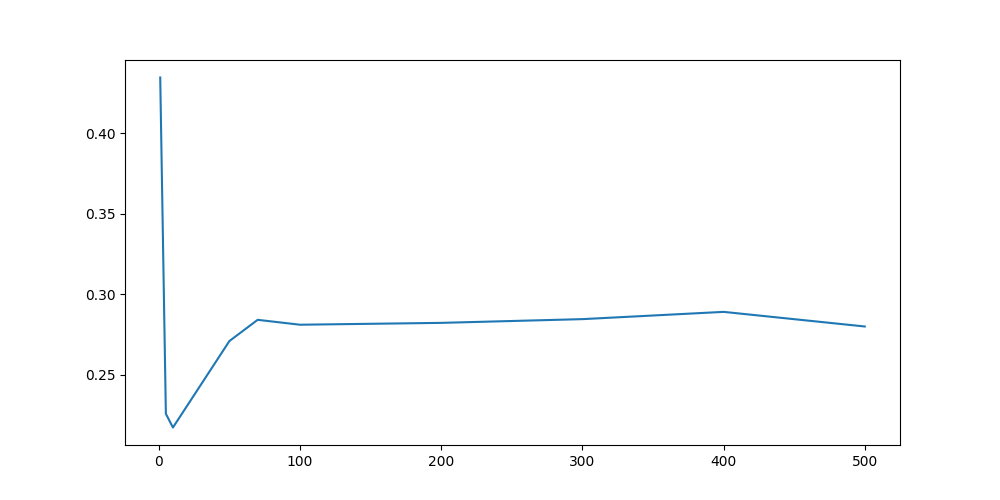

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(benchmark, times)
plt.show()

In [16]:
?time